<a href="https://colab.research.google.com/github/emmelinetsen/deep_learning/blob/master/assignment_4/Resnet_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [0]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim


In [2]:
# downloading CIFAR100 dataset
# transforming the PIL Image to tensors
train = torchvision.datasets.CIFAR100(root = "./data", train=True, download = True, transform = transforms.ToTensor())

#loading the training data from trainset
trainloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle = True)


Extracting ./data/cifar-100-python.tar.gz to ./data


## Resenet Architecture

In [0]:
# Reference https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/resnet.py

class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block 
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )
        
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))
        
class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the 
        same as a neuron netowork layer, ex. conv layer), one layer may 
        contain more than one residual block 
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block 
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        
        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output 

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [12]:
net = resnet18()
print(net)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [4]:
# view the training data

#iterating into the data
dataiter = iter(trainloader)
images, labels = dataiter.next()

# view the shape of 4 images
print(images.shape) 

# view the shape of 1 image
print(images[1].shape) 

# view the label of the first image
print(labels[1].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
51


<class 'torch.Tensor'>
(3, 32, 32)
(32, 32, 3)


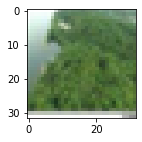

In [5]:
#taking the first image from batch of 4 images

img = images[0]
print(type(img))

#convert the tensor to numpy for displaying the image
npimg = img.numpy()
print(npimg.shape)

#for displaying the image, shape of the image should be height * width * channels
npimg = np.transpose(npimg, (1, 2, 0))
print(npimg.shape)

plt.figure(figsize = (2,2))
plt.imshow(np.squeeze(npimg))
plt.show()

In [6]:
# Training Resnet 

#increase the batch size
batch_size = 128

#download the data again and set the train, test loader with different batch size
train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
#reference a variable to gpu card to make the training faster
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
#create the model object and move it to GPU
net = resnet18().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

In [0]:
# method to calculate the accuracy on a gpu
def evaluate(dataloader):
    total, correct = 0, 0
    
    #keeping the network in evaluation mode
    net.eval()
    for data in dataloader:
        inputs, labels = data
        #moving the inputs and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Epoch: 0/1, Test acc: 19.63, Train acc: 20.86


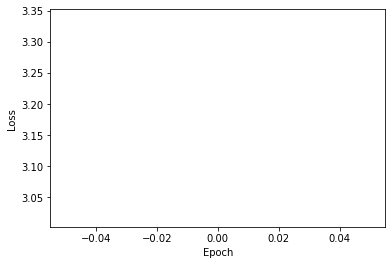

CPU times: user 54.5 s, sys: 24.4 s, total: 1min 18s
Wall time: 1min 19s


In [15]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 1

for epoch in range(max_epochs):
    #iterate through all the batches in each epoch
    for i, data in enumerate(trainloader, 0):
        
        #keeping the network in training mode
        net.train()
    
        inputs, labels = data
        #moving the input and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)
        #clear the gradients
        opt.zero_grad()
        #forward pass
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        #backward pass
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluate(testloader), evaluate(trainloader)))
    
    
plt.plot(loss_epoch_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()